#### pyrMeanShiftFiltering function
#### bilateraFilter
#### SimpleBlobDetector
#### Appy the Watershed algorithm

In [ ]:
%matplotlib inline
# import the necessary packages
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import cv2

Please upload the coins_02.png image.

In [ ]:
from google.colab import files
# please upload the input.jpg image here
uploaded = files.upload()

Saving coins_02.png to coins_02.png


In [ ]:
# get image name
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "coins_02.png" with length 328300 bytes


(383, 500, 3)
<class 'numpy.ndarray'>


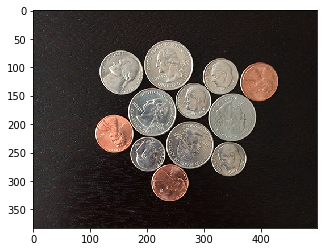

In [ ]:
# get image
# Load in Grayscale
img = cv2.imread(fn)
print(img.shape)
# The underlying representation is a numpy array!
print(type(img))

image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

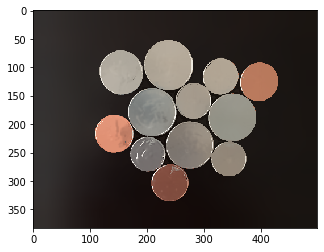

In [ ]:
# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
plt.imshow(shifted)
plt.show()

Q-1.  Please explain what pyrMeanShiftFiltering function is doing and why it is needed here.  What are the meaning of parameter values 21 & 51?  How to choose these 2 values?

Answer-1. 

##### The function implements the filtering stage of meanshift segmentation, that is, the output of the function is the filtered “posterized” image with color gradients and fine-grain texture flattened. At every pixel (X,Y) of the input image, the function executes meanshift iterations, that is, the pixel (X,Y) neighborhood in the joint space-color hyperspace is considered.

The reason to use here is to reduce details and remove noise for better edge detection.

sp=21 – The spatial window radius;
sr=51 – The color window radius.

For larger sp, meaning more pixels takes into operation; larger sr value causes higher effects. So larger sp or sr will make the image more smoothing and take more time to process. If the sp or sr is too small, the filter will not take too much effect.

Q-2. Add code to replace pyrMeanShiftFiltering with bilateraFilter on the original image

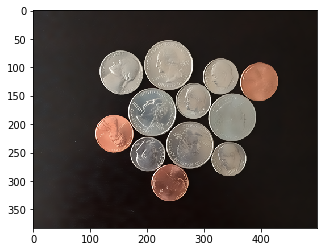

In [ ]:
#  Answer-2.  Add code to apply bilaeraFilter on image
shifted = cv2.bilateralFilter(image, 15, 70, 70)
plt.imshow(shifted)
plt.show()

Q-3. Add code to apply SimpleBlobDetector on shifted image

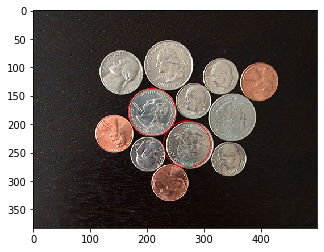

In [ ]:
# Answer-3. Modify the code below to apply SimpleBlobDetector on shifted
# the following code snippet may not work as is.  Please add your code to
# make it work as much as possible.
# Setup SimpleBlobDetector parameters.

params = cv2.SimpleBlobDetector_Params()
# Change thresholds
params.minThreshold = 10
params.maxThreshold = 200

# Filter by Area.
params.filterByArea = True
params.minArea = 50
params.maxArea = 6000

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.5

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.8

det = cv2.SimpleBlobDetector_create(params)
#detector = cv2.SimpleBlobDetector_create()

# Detect blobs
circles = det.detect(shifted)
 
# Draw detected blobs as red circles.
im_with_circles = cv2.drawKeypoints(image, circles, np.array([]), 255,
                                    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(im_with_circles)
plt.show()

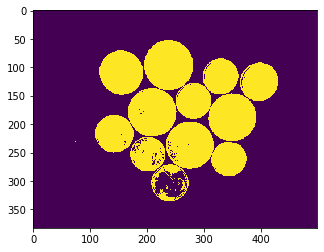

In [ ]:
# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)
plt.show()

Q-4.  In the previous output image, the bottom coin is lost after thresholding.  In the next code block, re-do the thresholding with newer parameters or apply your own pre-processing to improve the result.

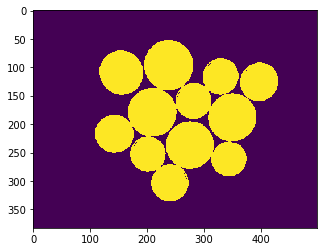

In [ ]:
# Answer-4.  Improve thresholding
shifted2 = cv2.pyrMeanShiftFiltering(image, 40, 80)
gray = cv2.cvtColor(shifted2, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 100, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)
plt.show()

In [ ]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,
	labels=thresh)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

[INFO] 12 unique segments found


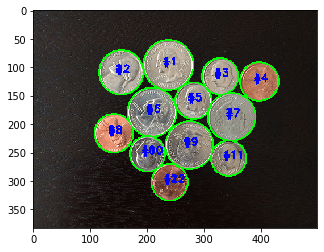

In [ ]:
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue

	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255

	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)[-2]
	c = max(cnts, key=cv2.contourArea)

	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# show the output image
plt.imshow(image)
plt.show()